<a href="https://colab.research.google.com/github/torontodeveloper/berkeley-ai-llm-foundations/blob/main/KevinKakollaNaturalLanguageProcessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Student Name: Kevin Kakolla
# Student Number: X257515

In [ ]:
#import libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
import plotly.express as px
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from tensorflow.keras import layers,models,Sequential

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
tf.debugging.set_log_device_placement(True)

In [ ]:
from google.colab import files
files.upload()

Saving kaggle (5).json to kaggle (5).json


{'kaggle (5).json': b'{"username":"nageswarraokakolla","key":"548ab64ccef1add72a9d2663b0b48f98"}'}

In [ ]:
# Make a directory named .kaggle
!mkdir -p ~/.kaggle

# Copy the kaggle.json to this new directory
!cp kaggle.json ~/.kaggle/

# Change the permissions of the file
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Install Kaggle API
!pip install kaggle

# Download the dataset
!kaggle competitions download -c friendsimdbratingprediction

  0% 0.00/1.61M [00:00<?, ?B/s]
100% 1.61M/1.61M [00:00<00:00, 159MB/s]


In [ ]:
!unzip /content/friendsimdbratingprediction.zip

Archive:  /content/friendsimdbratingprediction.zip
  inflating: friends_hackathon_zip (1)/friends_hackathon/friends_test_file.csv  
  inflating: friends_hackathon_zip (1)/friends_hackathon/friends_train_ratings.csv  
  inflating: friends_hackathon_zip (1)/friends_hackathon/season_01.csv  
  inflating: friends_hackathon_zip (1)/friends_hackathon/season_02.csv  
  inflating: friends_hackathon_zip (1)/friends_hackathon/season_03.csv  
  inflating: friends_hackathon_zip (1)/friends_hackathon/season_04.csv  
  inflating: friends_hackathon_zip (1)/friends_hackathon/season_05.csv  
  inflating: friends_hackathon_zip (1)/friends_hackathon/season_06.csv  
  inflating: friends_hackathon_zip (1)/friends_hackathon/season_07.csv  
  inflating: friends_hackathon_zip (1)/friends_hackathon/season_08.csv  


In [ ]:
friends_train_df = pd.read_csv('/content/friends_hackathon_zip (1)/friends_hackathon/friends_train_ratings.csv')

In [ ]:
friends_test_df = pd.read_csv('/content/friends_hackathon_zip (1)/friends_hackathon/friends_test_file.csv')

In [ ]:
friends_train_df.head(2)

,title,plot,ratings,date,total_reviews
0,The One Where Monica Gets a Roommate,"Monica and the gang introduce Rachel to the ""r...",8.3,22 Sep. 1994,"-8,583"
1,The One with the Sonogram at the End,Ross finds out his ex-wife is pregnant. Rachel...,8.0,29 Sep. 1994,"-6,607"


In [ ]:
friends_test_df.head(2)

,ID,title,plot,date,total_reviews,Transcripts,ratings
0,1,The One Where Emma Cries,"Chandler, having trouble getting enough sleep ...",3 Oct. 2002,"-4,033",\n\nThe One Where Emma Cries\n\n\n\nThe One Wh...,-
1,2,The One with the Pediatrician,Joey arranges a blind date for Phoebe. Chandle...,10 Oct. 2002,"-3,721",\n\n\n\n903 - The One With The Pediatrician\n\...,-


In [ ]:
friends_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title          195 non-null    object 
 1   plot           195 non-null    object 
 2   ratings        195 non-null    float64
 3   date           195 non-null    object 
 4   total_reviews  195 non-null    object 
dtypes: float64(1), object(4)
memory usage: 7.7+ KB


In [ ]:
px.histogram(friends_train_df,x='ratings',nbins=20,title='Ratings of episode in training')

In [ ]:
friends_train_df['date'] = pd.to_datetime(friends_train_df['date'],format="%d-%b-%y",errors='coerce')

In [ ]:
px.line(friends_train_df,x='date',y='ratings',title='Ratings of episode across different dates')

In [ ]:
px.line(friends_train_df,y='total_reviews',x='date',title='Number of reviews for episodes in training dataset')

In [ ]:
from transformers import BertTokenizer,BertModel
import torch

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
X_train_tokens = tokenizer(friends_train_df['plot'].astype('str').tolist(),padding=True,truncation=True,return_tensors='pt')

In [ ]:
X_test_tokens = tokenizer(friends_test_df['plot'].astype('str').tolist(),padding=True,truncation=True,return_tensors='pt')

In [ ]:
def get_bert_embeddings(tokens):
  with torch.no_grad():
    outputs = bert_model(**tokens)
    embeddings = outputs.last_hidden_state.mean(dim=1)
  return embeddings


In [ ]:
X_train_embeddings = get_bert_embeddings(X_train_tokens)

In [ ]:
X_test_embeddings = get_bert_embeddings(X_test_tokens)

In [ ]:
X_train_embeddings.shape

torch.Size([195, 768])

In [ ]:
sequence_length = X_train_embeddings.shape[0]
embedding_dim = X_train_embeddings.shape[1]

In [ ]:
X_train_embeddings = X_train_embeddings.reshape(-1,195,768)


In [ ]:
X_test_embeddings = X_test_embeddings.reshape(-1,35,768)

In [ ]:
X_train_embeddings.shape

torch.Size([1, 195, 768])

In [ ]:
X_test_embeddings.shape

torch.Size([1, 35, 768])

In [ ]:
model = Sequential()
model.add(tf.keras.Input(shape=(768,)))
model.add(layers.Flatten())
model.add(layers.Dense(32,activation='relu'))
model.add(layers.Dense(1))

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op FloorMod in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:loca

In [ ]:
model.compile(optimizer='adam',loss='mean_absolute_error',metrics=['mae'])

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0


In [ ]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)                  │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 32)                  │          24,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,641 (96.25 KB)

 Trainable params: 24,641 (96.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print(type(X_train_embeddings))
print(X_train_embeddings.dtype)
print(friends_train_df['ratings'].dtype)

<class 'numpy.ndarray'>
float32
float32


In [ ]:
X_train_embeddings = tf.cast(X_train_embeddings,dtype=tf.float32)
friends_train_df['ratings']=friends_train_df['ratings'].astype(np.float32)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0


In [ ]:
X_test_embeddings = tf.cast(X_test_embeddings,tf.float32)
# friends_test_df['ratings']=friends_test_df['ratings'].astype(np.float32)

In [ ]:
X_train_embeddings = tf.reshape(X_train_embeddings,(195,-1))

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Reshape in device /job:localhost/replica:0/task:0/device:GPU:0


In [ ]:
X_test_embeddings = tf.reshape(X_test_embeddings,(35,-1))

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Reshape in device /job:localhost/replica:0/task:0/device:GPU:0


In [ ]:
X_train_embeddings = np.array(X_train_embeddings, dtype=np.float32)
y_train = np.array(friends_train_df['ratings'], dtype=np.float32)

In [ ]:
X_train_embeddings.shape

(195, 768)

In [ ]:
y_train.shape

(195,)

In [ ]:
if np.any(np.isnan(X_train_embeddings)) or np.any(np.isnan(y_train)):
    print("There are NaN values in the data!")
if np.any(np.isinf(X_train_embeddings)) or np.any(np.isinf(y_train)):
    print("There are infinite values in the data!")

In [ ]:
X_train,X_valid,y_train,y_valid = train_test_split(X_train_embeddings,y_train,test_size=0.2,random_state=42)

In [ ]:
X_train.shape

(156, 768)

In [ ]:
y_train.shape

(156,)

In [ ]:
X_valid.shape

(39, 768)

In [ ]:
X_train.shape,X_valid.shape

((156, 768), (39, 768))

In [ ]:
y_train.shape,y_valid.shape

((156,), (39,))

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(156, 768)
(156,)
(39, 768)
(39,)


In [ ]:
history = model.fit(X_train,y_train,validation_data=(X_valid,y_valid),epochs=10,batch_size=32)

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Pr

In [ ]:
loss,mae = model.evaluate(X_valid,y_valid)

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Pr

#Visualization of Results

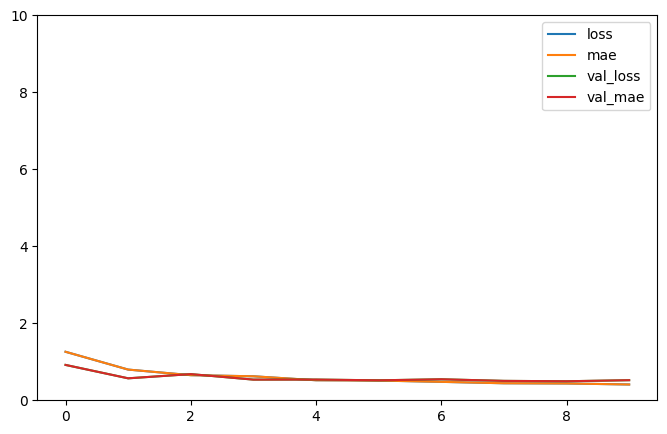

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.gca().set_ylim(0,10)
plt.show()

In [ ]:
y_predict_test = model.predict(X_test_embeddings)

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV3 in device /job:localhost/replica:0/task:0/device:CPU:0
Exe

# Prediction of Ratings for Test data episodes

In [ ]:
for index,prediction in enumerate(y_predict_test):
  print(f'Predicted rating for episode {index+1} => {prediction}')

Predicted rating for episode 1 => [7.9352713]
Predicted rating for episode 2 => [8.099145]
Predicted rating for episode 3 => [8.187528]
Predicted rating for episode 4 => [8.368564]
Predicted rating for episode 5 => [7.8905187]
Predicted rating for episode 6 => [7.471448]
Predicted rating for episode 7 => [8.601542]
Predicted rating for episode 8 => [8.471859]
Predicted rating for episode 9 => [7.3480973]
Predicted rating for episode 10 => [8.341857]
Predicted rating for episode 11 => [7.5728416]
Predicted rating for episode 12 => [8.465197]
Predicted rating for episode 13 => [7.307722]
Predicted rating for episode 14 => [8.723716]
Predicted rating for episode 15 => [7.847596]
Predicted rating for episode 16 => [8.214574]
Predicted rating for episode 17 => [9.0777445]
Predicted rating for episode 18 => [8.489818]
Predicted rating for episode 19 => [8.107761]
Predicted rating for episode 20 => [8.183797]
Predicted rating for episode 21 => [8.218577]
Predicted rating for episode 22 => [7.

In [ ]:
print('Loss is',loss)
print('MAE is',mae)

Loss is 0.5217361450195312
MAE is 0.5217361450195312


##
Loss - 0.5217361450195312- and MAE(0.5217361450195312). For some reason, loss and mae has gone up if i apply Dropout() and BatchNormalization overfitting techniques
We can still make changes with hyperparameter tuning like chaning learning rate, change optimizers and acitvation function combination to see if model performance improves